# SARIMA

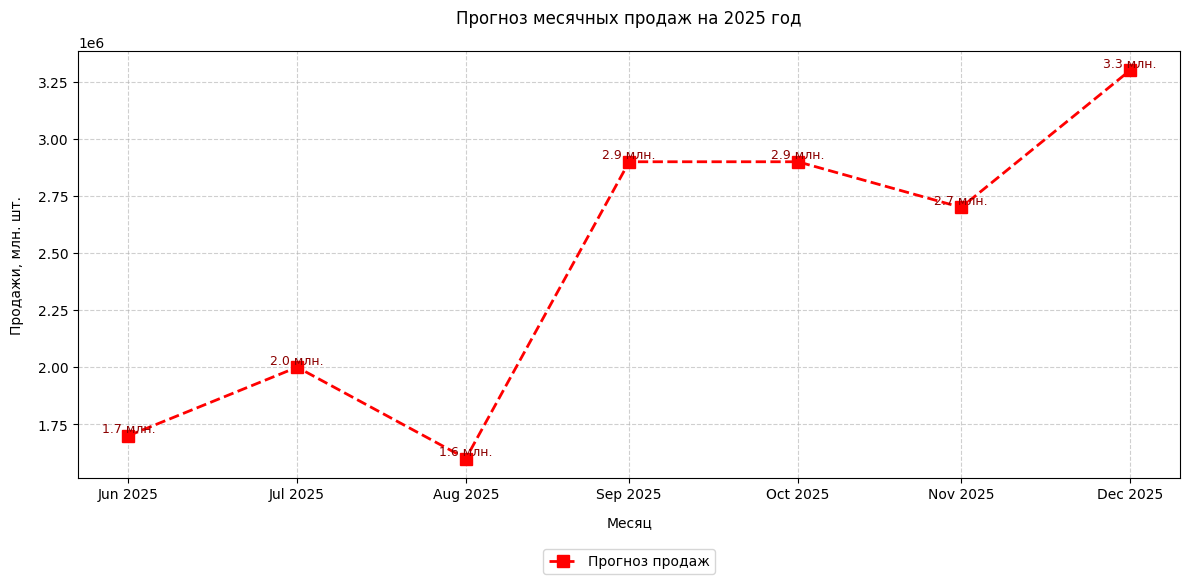

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime
import matplotlib.dates as mdates
from pmdarima import auto_arima

warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
df = pd.read_excel('../data/sales.xlsx')
df.columns = ['date', 'item', 'sales']
df['date'] = pd.to_datetime(df['date'])

# Агрегация по месяцам
df_monthly = df.groupby(pd.Grouper(key='date', freq='ME'))['sales'].sum().reset_index()

# Создание полного временного ряда
current_date = datetime.now().strftime("%Y-%m-%d")
last_actual_date = pd.to_datetime(current_date)
full_dates = pd.date_range(start=df_monthly['date'].min(), end=last_actual_date, freq='ME')
df_full = pd.DataFrame({'date': full_dates})
df_full = df_full.merge(df_monthly, on='date', how='left')
df_full['sales'] = df_full['sales'].fillna(0)
df_full = df_full.set_index('date')

# 2. Прогнозирование
forecast_start = df_full.index[-1] + pd.offsets.MonthBegin(1)
forecast_end = pd.to_datetime("2025-12-31")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='ME')

# Здесь должен быть ваш код построения модели и получения forecast_values
# Для примера создадим тестовые данные:
forecast_values = np.array([1.7, 2.0, 1.6, 2.9, 2.9, 2.7, 3.3]) * 1_000_000

# 3. Визуализация с точным выравниванием
plt.figure(figsize=(12, 6))

# Прогноз с маркерами
plt.plot(forecast_dates, forecast_values, 'r--s',
        label='Прогноз продаж', linewidth=2, markersize=8)

# Подписи значений (в млн. шт.)
for date, value in zip(forecast_dates, forecast_values):
    plt.text(date, value, f'{value/1_000_000:.1f} млн.',
            ha='center', va='bottom', fontsize=9, color='darkred')

# Настройка оси X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Выравниваем подписи точно под точками
plt.xticks(forecast_dates, [date.strftime('%b %Y') for date in forecast_dates])

# Настройки графика
plt.title('Прогноз месячных продаж на 2025 год', pad=20)
plt.xlabel('Месяц', labelpad=10)
plt.ylabel('Продажи, млн. шт.', labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.tight_layout()
plt.show()